# Change Tests - with time
A notebook for testing change detection using recently implemented time dimension within classification.

Requires the `temporal_info_for_change branch` of livingearth_lccs.

In [1]:
import logging
import os
import sys
import yaml

import numpy
import xarray
from matplotlib import pyplot

# Import le_lccs modules (added from DPSIR.ipynb to allow export)
sys.path.append("/home/jovyan/development/livingearth_lccs")
from le_lccs import le_ingest
from le_lccs import le_export

sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_australia/le_plugins"))
sys.path.append("/home/jovyan/development/livingearth_lccs")
sys.path.append("/home/jovyan/development/dea-notebooks/Scripts")
sys.path.append("/home/jovyan/development/livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = "/home/jovyan/development/livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_utils import gridded_classification
from le_lccs.le_classification import simple_change
from le_lccs.le_classification import evidence_based_change

In [2]:
def export_to_geotiff(data_xarray, output_filename):
    """
    Convenience function to write out as GeoTiff using le_lccs export class
    (based on rasterio)
    """
    export_parameters = {}
    export_parameters["output_file"] = output_filename
    # Use a float for output and cast all output layer to this
    export_parameters["out_dtype"] = numpy.uint8
    export_parameters["cast_to_out_dtype"] = True
    # Get export class to use
    export_class = le_export.gridded_export.LEExportGDAL
    export_obj = export_class(**target_size)
    # Write out xarray
    export_obj.write_xarray(data_xarray, **export_parameters)

In [3]:
# Set up logger
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

In [4]:
## Set up some useful functions
def update_config_year(in_config, in_year, out_year):
    """
    Set up function to replace year in config file
    """
    # If no change to config is required just return
    if in_year == out_year:
        return in_config
    
    with open(in_config, "r") as f:
        config_text = f.read()
    config_text = config_text.replace(in_year, out_year)
    
    out_config = in_config.replace(in_year, out_year)
    
    with open(out_config, "w") as f:
        f.write(config_text)
    
    return out_config

def write_compressed_netcdf(data_xarray, output_file):
    """
    Write out a compressed netCDF file
    """
    # Get a list of variables
    variable_names_list  = [var for var in data_xarray.data_vars]

    # Set up encoding options for output
    out_encoding_options={"zlib" : True, "complevel" : 4}
    out_nc_encoding = {}
    for var_name in variable_names_list:
        out_nc_encoding[var_name] = out_encoding_options

        data_xarray[variable_names_list].to_netcdf(
            output_file, format="NETCDF4", engine="netcdf4",
            encoding=out_nc_encoding)

In [5]:
# Set up base config file (from 2015). Will create a copy of this for each year
config_file_2015 = "./configs/l4_vp_2015.yaml"

In [6]:
# Open config file containing all site extents. Can define manually but this makes it a bit easier
# to run our study sites
yaml_sites_file = os.path.abspath("../cultivated_ml/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

In [7]:
# Set up parameters for specific site
site_name = "Murray Valley"

extent = [site_config[site_name]["min_x"],
          site_config[site_name]["min_y"],
          site_config[site_name]["max_x"],
          site_config[site_name]["max_y"]]

# Try tp make directory for outputs, if it exists then pass
output_dir = "./outputs"
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

In [8]:
# Set up dictionary to define size parameters
# For tests can use a reduced resolution (e.g., 100) to run through faster
target_size = {}

target_size["target_min_x"] = extent[0]
target_size["target_max_x"] = extent[2]
target_size["target_min_y"] = extent[1]
target_size["target_max_y"] = extent[3]

target_size["target_pixel_size_x"] = 100
target_size["target_pixel_size_y"] = -100

target_size["target_crs"] = "EPSG:3577"

In [9]:
classification_all_outputs_list = []
classification_years = ["2005", "2010", "2015", "2017"]

for year in classification_years:

    print(f"Running for {year}")
    config_file_year = update_config_year(config_file_2015, "2015", year)

    out_name_base = "lccs_l4_tests_{}_{}".format(site_name.replace(" ","_"), year)
    output_l3_file_name = os.path.join(output_dir, "{}_level3.tif".format(out_name_base))
    output_l3_rgb_file_name = os.path.join(output_dir, "{}_level3_rgb.tif".format(out_name_base))
    output_l4_file_name = os.path.join(output_dir, "{}_level4.tif".format(out_name_base))
    output_l4_rgb_file_name = os.path.join(output_dir, "{}_level4_rgb.tif".format(out_name_base))
    output_classification_data_file = os.path.join(output_dir, "{}_classification_data.nc".format(out_name_base))
    
    # If output from previous run exists load this, else run classification
    if os.path.isfile(output_classification_data_file):
        classification_year = xarray.open_dataset(output_classification_data_file)
        print(f"Loaded existing classification from {output_l4_file_name}")
    else:
        print("Running classification, may take a while...")
        classification_year = gridded_classification.run_classification(config_file_year, extent=extent,
                                                                        output_l3_file_name=output_l3_file_name, output_l3_rgb_file_name=output_l3_rgb_file_name,
                                                                        output_l4_file_name=output_l4_file_name, output_l4_rgb_file_name=output_l4_rgb_file_name)
        # Save to netCDF for faster loading in future
        write_compressed_netcdf(classification_year, output_classification_data_file)
    classification_all_outputs_list.append(classification_year)

Running for 2005
Loaded existing classification from ./outputs/lccs_l4_tests_Murray_Valley_2005_level4.tif
Running for 2010
Loaded existing classification from ./outputs/lccs_l4_tests_Murray_Valley_2010_level4.tif
Running for 2015
Loaded existing classification from ./outputs/lccs_l4_tests_Murray_Valley_2015_level4.tif
Running for 2017
Loaded existing classification from ./outputs/lccs_l4_tests_Murray_Valley_2017_level4.tif


In [12]:
# The cool part - merge two years together as one x array with a time dimension
classification_all = xarray.merge(classification_all_outputs_list)

In [13]:
classification_all

<xarray.Dataset>
Dimensions:                  (time: 4, x: 1000, y: 1000)
Coordinates:
  * time                     (time) datetime64[ns] 2005-12-31 ... 2017-12-31
  * x                        (x) float64 1.1e+06 1.1e+06 ... 1.2e+06 1.2e+06
  * y                        (y) float64 -3.9e+06 -3.9e+06 ... -4e+06 -4e+06
    spatial_ref              int32 3577
Data variables:
    fc_veg                   (time, y, x) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    wcf_mask                 (time, y, x) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    woody_cover              (time, y, x) float64 0.1007 0.09913 ... 0.009527
    cultman_agr_cat          (time, y, x) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0
    tf_urban_classification  (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mads_urban_mask_sdev     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mads_urban_mask_edev     (time, y, x) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    wofs_mask                (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    item_v2_mask             (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mangrove                 (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lifeform_veg_cat         (time, y, x) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    canopyco_veg_con         (time, y, x) float64 18.5 21.5 20.0 ... 41.0 29.5
    waterper_wat_cin         (time, y, x) float64 10.59 10.59 10.91 ... 0.0 0.0
    watersea_veg_cat         (time, y, x) float64 2.0 2.0 2.0 ... 0.0 0.0 0.0
    vegetat_veg_cat          (time, y, x) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    artific_urb_cat          (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    aquatic_wat_cat          (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    inttidal_wat_cat         (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waterstt_wat_cat         (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    level3                   (time, y, x) float64 111.0 111.0 ... 112.0 112.0
    lifeform_veg_cat_l4a     (time, y, x) float64 2.0 2.0 2.0 ... 2.0 2.0 2.0
    canopyco_veg_cat_l4d     (time, y, x) float64 13.0 13.0 13.0 ... 12.0 13.0
    watersea_veg_cat_l4a     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waterstt_wat_cat_l4a     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waterper_wat_cat_l4d     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    inttidal_wat_cat_l4a     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Red                      (time, y, x) float64 242.0 242.0 ... 136.0 153.0
    Green                    (time, y, x) float64 240.0 240.0 ... 182.0 196.0
    Blue                     (time, y, x) float64 127.0 127.0 ... 51.0 80.0

In [14]:
#Original: canopy_cov_diff = classification_all["canopyco_veg_con"][0] - classification_all["canopyco_veg_con"][-1]

In [15]:
# Separate out and drop time dimension for current change tools.
classification_2005_select = classification_all.where(
    (classification_all.time >= numpy.datetime64("2005")) & (classification_all.time < numpy.datetime64("2006")), drop=True)
classification_2005_select = classification_2005_select.squeeze("time").drop("time")
classification_2010_select = classification_all.where(
    (classification_all.time >= numpy.datetime64("2010")) & (classification_all.time < numpy.datetime64("2011")), drop=True)
classification_2010_select = classification_2010_select.squeeze("time").drop("time")
classification_2015_select = classification_all.where(
    (classification_all.time >= numpy.datetime64("2015")) & (classification_all.time < numpy.datetime64("2016")), drop=True)
classification_2015_select = classification_2015_select.squeeze("time").drop("time")
classification_2017_select = classification_all.where(
    (classification_all.time >= numpy.datetime64("2017")) & (classification_all.time < numpy.datetime64("2018")), drop=True)
classification_2017_select = classification_2017_select.squeeze("time").drop("time")

In [16]:
print("Calculating simple change...")
# Calculate level4 change for all available classes
out_change = simple_change.get_lccs_l4_change_codes(
    classification_2010_select,
    classification_2015_select,
    ignore_no_change=False)

Calculating simple change...


In [17]:
print("Calculating evidence based change pairs...")
out_evidence_based_change = evidence_based_change.get_evidence_based_change_pairs(
    out_change, classification_2010_select, classification_2015_select)

Calculating evidence based change pairs...


In [18]:
# Note that if have 2005, 2010, 2015 and 2017 (for example), then 2005=0, 2010=1, 2015 =2 and 2017=3
canopy_cov_diff = classification_all["canopyco_veg_con"][1] - classification_all["canopyco_veg_con"][2]

In [20]:
out_evidence_based_change

<xarray.Dataset>
Dimensions:                (x: 1000, y: 1000)
Coordinates:
    spatial_ref            int32 3577
  * x                      (x) float64 1.1e+06 1.1e+06 ... 1.2e+06 1.2e+06
  * y                      (y) float64 -3.9e+06 -3.9e+06 ... -4e+06 -4e+06
Data variables:
    ctv_extent             (y, x) uint8 0 0 0 0 0 2 0 0 0 ... 0 0 0 0 0 1 0 0 0
    ntv_extent             (y, x) uint8 0 0 0 0 0 1 0 0 0 ... 0 0 0 0 0 2 0 0 0
    nav_extent             (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    as_extent              (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    bs_extent              (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    w_extent               (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ctv_ps                 (y, x) uint8 2 2 2 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nav_ps                 (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ntv_woody_ps           (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ntv_herbaceous_ps      (y, x) uint8 0 0 0 0 0 0 2 0 0 ... 0 0 0 0 0 0 0 0 0
    ntv_woody_extent       (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ntv_herbaceous_extent  (y, x) uint8 0 0 0 0 0 1 0 0 0 ... 0 0 0 0 0 2 0 0 0
    water_persistence      (y, x) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

#### Differencing continuous layers

In [21]:
canopy_cov_time_diff = classification_all["canopyco_veg_con"][1].time - classification_all["canopyco_veg_con"][2].time

In [22]:
canopy_cov_time_diff = numpy.timedelta64(int(365.25*6), "D")

In [23]:
waterper_wat_diff = classification_all["waterper_wat_cin"][1] - classification_all["waterper_wat_cin"][2]

In [24]:
waterper_wat_time_diff = classification_all["waterper_wat_cin"][1].time - classification_all["waterper_wat_cin"][2].time

In [25]:
waterper_wat_time_diff = numpy.timedelta64(int(365.25*6), "D")

In [26]:
woody_cover_diff = classification_all["woody_cover"][1] - classification_all["woody_cover"][2]

In [27]:
woody_cover_time_diff = classification_all["woody_cover"][1].time - classification_all["woody_cover"][2].time

In [28]:
woody_cover_time_diff = numpy.timedelta64(int(365.25*6), "D")

#### OBSERVED CHANGES
No change (0); Increase in extent/cover/persistence (1) and decrease in extent/cover/persistence (2)

### <font color=green>**Cultivated Terrestrial Vegetation**</font>
#### <font color=blue>**Changes in extent**</font>
Default: *(e.g., agricultural_area_loss_ABANDONMENT = numpy.where((out_evidence_based_change["ctv_extent"]== 2), 1, 0)*

#####  **Agricultural area loss (abandonment)**:  
##### ***Suggested datasets:***  *Economic, prior history*


In [29]:
agricultural_area_loss_ABANDONMENT = numpy.where((out_evidence_based_change["ctv_extent"]== 2) & (classification_all["level3"][3].time != 111), 1, 0)

##### **Temporary agricultural area loss (reduced product demand)**
##### ***Suggested datasets:***  *Economic, prior history*

In [30]:
temporary_agricultural_area_loss_REDUCED_PRODUCT_DEMAND = numpy.where((out_evidence_based_change["ctv_extent"]== 2) & (classification_all["level3"][3].time == 111), 1, 0)

##### **Agricultural area gain (increased product demand)**
##### ***Suggested datasets:***  *Economic, prior history*

In [31]:
agricultural_area_gain_INCREASED_PRODUCT_DEMAND = numpy.where((out_evidence_based_change["ctv_extent"]== 1)& (classification_all["level3"][3].time == 111), 1, 0)

##### **Vegetation gain (urban greening)**
##### ***Suggested datasets:***  *Economic, prior history*

In [32]:
vegetation_gain_URBAN_GREENING = numpy.where((out_evidence_based_change["ctv_extent"]== 1), 1, 0)

#### <font color=blue>**Changes in amount/condition**</font>

#####  **Crop change (crop rotation)**
##### ***Suggested datasets:***  *previous year classification*

In [33]:
crop_change_CROP_ROTATION = numpy.where((out_evidence_based_change["ctv_ps"]== 1) | (out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop change (drought)**
##### ***Suggested datasets:***  *previous year classification*

In [34]:
crop_damage_DROUGHT = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop change (crop rotation)**
##### ***Suggested datasets:***  *previous year classification*

In [35]:
crop_damage_INCREASED_PRECIPITATION = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop damage (increased precipitation)**
##### ***Suggested datasets:***  *previous year classification*

In [36]:
crop_damage_INCREASED_WIND = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop damage (increased wind)**
##### ***Suggested datasets:***  *previous year classification*

In [37]:
crop_damage_FLOOD = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop damage (flood)**
##### ***Suggested datasets:***  *previous year classification*

In [38]:
crop_damage_GRAZING = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop loss (overgrazing)**
##### ***Suggested datasets:***  *previous year classification*

In [39]:
crop_loss_OVERGRAZING = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

#####  **Crop loss (stubble burning)**
##### ***Suggested datasets:***  *previous year classification*

In [40]:
crop_loss_OVERGRAZING = numpy.where((out_evidence_based_change["ctv_ps"]== 2), 1, 0)

##### **Bare soil exposure (tillage)**
##### ***Suggested datasets:***  *previous year classification*

In [41]:
bare_soil_exposure_TILLAGE = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

##### **Bare soil exposure (ploughing)**
##### ***Suggested datasets:***  *previous year classification*

In [42]:
bare_soil_exposure_PLOUGHING = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

##### **Crop gain (removal from fallow)**
##### ***Suggested datasets:***  *previous year classification*

In [43]:
crop_gain_REMOVAL_FROM_FALLOW = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

##### **Crop gain (seeding/planting)**
##### ***Suggested datasets:***  *previous year classification*

In [44]:
crop_gain_SEEDING_PLANTING = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

##### **Vegetation health improvement (irrigation)**
##### ***Suggested datasets:***  *previous year classification*

In [45]:
vegetation_health_improvement_IRRIGATION = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

##### **Vegetation health improvement (fertiliser application)**
##### ***Suggested datasets:***  *previous year classification*

In [46]:
vegetation_health_improvement_FERTILISER_APPLICATION = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

##### **Vegetation increase(urban greening)**
##### ***Suggested datasets:***  *previous year classification*

In [47]:
vegetation_increase_URBAN_GREENING = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

### <font color=green>**Natural Terrestrial Vegetation (Both woody and Herbaceous)**</font>
#### <font color=blue>**Changes in extent**</font>

#####  **Vegetation gain (land abandonment)**
##### ***Suggested datasets:***  *previous year classification*

In [48]:
vegetation_gain_LAND_ABANDONMENT = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#####  **Vegetation gain (afforestation)**
##### ***Suggested datasets:***  *previous year classification*

In [49]:
vegetation_gain_AFFORESTATION = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#####  **Vegetation gain (revegetation)**
##### ***Suggested datasets:***  *previous year classification*

In [50]:
vegetation_gain_REVEGETATION = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#####  **Vegetation gain (enchroachment)**
##### ***Suggested datasets:***  *previous year classification*

In [51]:
vegetation_gain_ENCHROACHMENT = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#### <font color=blue>**Changes in amount/condition**</font>

#####  **Vegetation change (invasive species - terrestrial)**
##### ***Suggested datasets:***  *previous year classification*

In [52]:
vegetation_change_INVASIVE_SPECIES_TERRESTRIAL = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation change (control of terrestrial invasive species)**
##### ***Suggested datasets:***  *previous year classification*

In [53]:
vegetation_change_CONTROL_TERRESTRIAL_INVASIVES = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation gain (fertilizer application)**
##### ***Suggested datasets:***  *previous year classification*

In [54]:
vegetation_gain_FERTILIZER_APPLICATION = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation gain (succession)**
##### ***Suggested datasets:***  *previous year classification*

In [55]:
vegetation_gain_SUCCESSION = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation gain (regrowth)**
##### ***Suggested datasets:***  *previous year classification*

In [56]:
vegetation_gain_REGROWTH = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation gain (restoration)**
##### ***Suggested datasets:***  *previous year classification*

In [57]:
vegetation_gain_RESTORATION = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation reduction (prescribed burn)**
##### ***Suggested datasets:***  *previous year classification*

In [58]:
vegetation_reduction_PRESCRIBED_BURN = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Dieback (drought)**
##### ***Suggested datasets:***  *previous year classification*

In [59]:
dieback_DROUGHT = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Dieback (herbivory)**
##### ***Suggested datasets:***  *previous year classification*

In [60]:
dieback_HERBIVORY = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Dieback (insects)**
##### ***Suggested datasets:***  *previous year classification*

In [61]:
dieback_INSECTS = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Dieback (pathogens)**
##### ***Suggested datasets:***  *previous year classification*

In [62]:
dieback_PATHOGENS = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Dieback (prolonged inundation)**
##### ***Suggested datasets:***  *previous year classification*

In [63]:
dieback_PROLONGED_INUNDATION = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation damage (frost)**
##### ***Suggested datasets:***  *previous year classification*

In [64]:
vegetation_damage_FROST = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation damage (prolonged snow cover)**
##### ***Suggested datasets:***  *previous year classification*

In [65]:
vegetation_damage_PROLONGED_SNOWCOVER = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation loss (wildfire)**
##### ***Suggested datasets:***  *previous year classification*

In [66]:
vegetation_loss_WILDFIRE = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation reduction (increased wind)**
##### ***Suggested datasets:***  *previous year classification*

In [67]:
vegetation_reduction_INCREASED_WIND = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation reduction (herbivory)**
##### ***Suggested datasets:***  *previous year classification*

In [68]:
vegetation_reduction_HERBIVORY = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation reduction (desertification)**
##### ***Suggested datasets:***  *previous year classification*

In [69]:
vegetation_reduction_DESERTIFICATION = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

#####  **Vegetation change (day length and/or temperature)**
##### ***Suggested datasets:***  *previous year classification*

In [70]:
vegetation_change_DAY_LENGTH_TEMPERATURE = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

### <font color=green>**Natural Terrestrial Vegetation (Woody)**</font>
#### <font color=blue>**Changes in extent**</font>

#####  **Vegetation increase (reforestation - natural)**
##### ***Suggested datasets:***  *previous year classification*

In [71]:
vegetation_increase_REFORESTATION_NATURAL = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#####  **Vegetation increase (reforestation - plantations)**
##### ***Suggested datasets:***  *previous year classification*

In [72]:
vegetation_increase_REFORESTATION_PLANTATION = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#####  **Vegetation loss (deforestation - plantations)**
##### ***Suggested datasets:***  *previous year classification*

In [73]:
vegetation_loss_DEFORESTATION = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

#### <font color=blue>**Changes in amount/condition**</font>

#####  **Vegetation increase (woody thickening)**
##### ***Suggested datasets:***  *previous year classification*

In [74]:
vegetation_increase_WOODY_THICKENING = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2), 1, 0)

#####  **Vegetation reduction (selective logging)**
##### ***Suggested datasets:***  *previous year classification*

In [75]:
vegetation_reduction_SELECTIVE_LOGGING = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2), 1, 0)

#####  **Vegetation reduction (thinning)**
##### ***Suggested datasets:***  *previous year classification*

In [76]:
vegetation_loss_THINNING = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2), 1, 0)

### <font color=green>**Cultivated Aquatic Vegetation**</font>
#### <font color=blue>**Changes in extent**</font>

#####  **Gain in aquaculture (aquaculture expansion)**
##### ***Suggested datasets:***  *previous year classification*

In [77]:
gain_in_aquaculture_EXPANSION = numpy.where((out_evidence_based_change["cav_extent"]== 2), 1, 0)

KeyError: 'cav_extent'

#####  **Loss of aquaculture (abandonment)**
##### ***Suggested datasets:***  *previous year classification*

In [78]:
loss_of_aquaculture_ABANDONMENT = numpy.where((out_evidence_based_change["cav_extent"]== 2), 1, 0)

KeyError: 'cav_extent'

### <font color=green>**Natural Aquatic Vegetation**</font>
#### <font color=blue>**Changes in extent**</font>

#####  **Algal bloom (increased temperatures)**
##### ***Suggested datasets:***  *previous year classification*

In [79]:
algal_bloom_INCREASED_TEMPERATURES = numpy.where((out_evidence_based_change["nav_ps"]== 2), 1, 0)

#### <font color=blue>**Changes in amount/conditions**</font>

#####  **Dieback (sea level fluctuation)**
##### ***Suggested datasets:***  *previous year classification*

In [80]:
dieback_SEA_LEVEL_FLUCTUATION = numpy.where((out_evidence_based_change["nav_extent"]== 1), 1, 0)

#####  **Dieback (mooring/anchoring)**
##### ***Suggested datasets:***  *previous year classification*

In [81]:
dieback_MOORING_ANCHORING = numpy.where((out_evidence_based_change["nav_ps"]== 2), 1, 0)

#####  **Coral bleaching (increased sea temperatures)**
##### ***Suggested datasets:***  *previous year classification*

In [82]:
coral_bleaching_INCREASED_SEA_TEMPERATURES = numpy.where((out_evidence_based_change["nav_ps"]== 2), 1, 0)

#####  **Vegetation health improvement (coral recovery)**
##### ***Suggested datasets:***  *previous year classification*

In [83]:
coral_recovery_VEGETATION_HEALTH_IMPROVEMENT = numpy.where((out_evidence_based_change["nav_ps"]== 2), 1, 0)

#####  **Vegetation change (aquatic invasives)**
##### ***Suggested datasets:***  *previous year classification*

In [84]:
vegetation_change_AQUATIC_INVASIVES = numpy.where((out_evidence_based_change["nav_ps"]== 2), 1, 0)

#####  **Vegetation change (control of aquatic invasives)**
##### ***Suggested datasets:***  *previous year classification*

In [85]:
vegetation_change_CONTROL_OF_AQUATIC_INVASIVES = numpy.where((out_evidence_based_change["ntv_woody_ps"]== 2)|(out_evidence_based_change["ntv_herbaceous_ps"]== 2), 1, 0)

### <font color=green>**Artificial Surfaces**</font>
#### <font color=blue>**Changes in extent**</font>

#####  **Urban development (construction - aquaculture farm)**
##### ***Suggested datasets:***  *previous year classification*

In [86]:
urban_development_CONSTRUCTION_AQUACULTURE = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#####  **Urban development (construction - dams)**
##### ***Suggested datasets:***  *previous year classification*

In [87]:
urban_development_CONSTRUCTION_DAMS = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#####  **Urban development (levelling)**
##### ***Suggested datasets:***  *previous year classification*

In [88]:
urban_development_CONSTRUCTION_LEVELLING = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#####  **Urban development (construction - railways)**
##### ***Suggested datasets:***  *previous year classification*

In [89]:
urban_development_CONSTRUCTION_RAILWAYS = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#####  **Urban development (construction - roads)**
##### ***Suggested datasets:***  *previous year classification*

In [90]:
urban_development_CONSTRUCTION_ROADS = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#####  **Urban development (construction - mines)**
##### ***Suggested datasets:***  *previous year classification*

In [91]:
urban_development_CONSTRUCTION_MINES = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#####  **Urban expansion (constructions - buildings)**
##### ***Suggested datasets:***  *previous year classification*

In [92]:
urban_development_CONSTRUCTION_BUILDINGS = numpy.where((out_evidence_based_change["as_extent"]== 1), 1, 0)

#### <font color=blue>**Changes in amount/condition**</font>

#####  **Artificial surface loss (subsidence)**
##### ***Suggested datasets:***  *previous year classification*

In [93]:
artificial_surface_loss_SUBSIDENCE = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Mine abandonment (reduced resources or demand)**
##### ***Suggested datasets:***  *previous year classification*

In [94]:
mine_abandonment_REDUCED_RESOURCES_DEMAND = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban damage (fire)**
##### ***Suggested datasets:***  *previous year classification*

In [95]:
urban_damage_FIRE = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban damage (urban fire)**
##### ***Suggested datasets:***  *previous year classification*

In [96]:
urban_damage_URBAN_FIRE = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban damage (increased winds)**
##### ***Suggested datasets:***  *previous year classification*

In [97]:
urban_damage_INCREASED_WINDS = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban damage (flooding)**
##### ***Suggested datasets:***  *previous year classification*

In [98]:
urban_damage_FLOODING = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban decay (building abandonment)**
##### ***Suggested datasets:***  *previous year classification*

In [99]:
urban_decay_BUILDING_ABANDONMENT = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban decay (railway abandonment)**
##### ***Suggested datasets:***  *previous year classification*

In [100]:
urban_decay_RAILWAY_ABANDONMENT = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban decay(road abandonment)**
##### ***Suggested datasets:***  *previous year classification*

In [101]:
urban_decay_ROAD_ABANDONMENT = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban development (densification)**
##### ***Suggested datasets:***  *previous year classification*

In [102]:
urban_development_DENSIFICATION = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Urban renewal(storm damage repair)**
##### ***Suggested datasets:***  *previous year classification*

In [103]:
urban_renewal_STORM_DAMAGE_REPAIR = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

### <font color=green>**Natural Bare Surfaces**</font>
#### <font color=blue>**Changes in amount/condition**</font>

#####  **Landslide (elevation change)**
##### ***Suggested datasets:***  *previous year classification*

In [104]:
landslide_ELEVATION_CHANGE = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Erosion (flooding)**
##### ***Suggested datasets:***  *previous year classification*

In [105]:
erosion_FLOODING = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Erosion (increased wind)**
##### ***Suggested datasets:***  *previous year classification*

In [106]:
erosion_INCREASED_WIND = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Natural surface loss (subsidence)**
##### ***Suggested datasets:***  *previous year classification*

In [107]:
natural_surface_loss_SUBSIDENCE = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Natural surface loss (mining)**
##### ***Suggested datasets:***  *previous year classification*

In [108]:
natural_surface_loss_MINING = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Sink hole (land surface collapse)**
##### ***Suggested datasets:***  *previous year classification*

In [109]:
sink_hole_LAND_SURFACE_COLLAPSE = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Accretion (sediment transport)**
##### ***Suggested datasets:***  *previous year classification*

In [110]:
accretion_SEDIMENT_TRANSPORT = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Lava flow (volcanic eruption)**
##### ***Suggested datasets:***  *previous year classification*

In [111]:
lava_flow_VOLCANIC_ERUPTION = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

#####  **Deposition (natural surface gain)**
##### ***Suggested datasets:***  *previous year classification*

In [112]:
deposition_NATURAL_SURFACE_GAIN = numpy.where((out_evidence_based_change["bs_ps"]== 2), 1, 0)

KeyError: 'bs_ps'

### <font color=green>**Water (Artificial or Natural)**</font>
#### <font color=blue>**Changes in extent**</font>

#####  **Deglaciation (increased temperatures)**
##### ***Suggested datasets:***  *previous year classification*

In [113]:
deglaciation_INCREASED_TEMPERATURE = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#####  **Sea level fall (oscillation of ocean-atmospheric system)**
##### ***Suggested datasets:***  *previous year classification*

In [114]:
sea_level_fall_OSCILLATION_OCEAN_ATMOSPHERE_SYSTEM = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#####  **Water loss (drying)**
##### ***Suggested datasets:***  *previous year classification*

In [115]:
water_loss_DRYING = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#####  **Water loss (land reclamation)**
##### ***Suggested datasets:***  *previous year classification*

In [116]:
water_loss_LAND_RECLAMATION = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#####  **Water loss (wetland/waterbody draining)**
##### ***Suggested datasets:***  *previous year classification*

In [117]:
water_loss_WETLAND_WATERBODY_DRAINING = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#####  **Inundation (increased precipitation)**
##### ***Suggested datasets:***  *previous year classification*

In [118]:
inundation_INCREASED_PRECIPITATION = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#####  **Sea level rise (melting icesheets/glaciers, thermal expansion)**
##### ***Suggested datasets:***  *previous year classification*

In [119]:
sea_level_rise_MELTING_ICE_THERMAL_EXPANSION = numpy.where((out_evidence_based_change["w_extent"]== 2), 1, 0)

#### <font color=blue>**Changes in amount/conditions**</font>

#####  **Blackwater event (inundation following extended drought)**
##### ***Suggested datasets:***  *previous year classification*

In [120]:
blackwater_event_INUNDATION_POST_EXTENDED_DROUGHT = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

##### **Increased sediment load (sedimentation)**
##### ***Suggested datasets:***  *previous year classification*

In [121]:
increased_sediment_loads_SEDIMENTATION = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

##### **Net snow hydroperiod loss (increased temperature)**
##### ***Suggested datasets:***  *previous year classification*

In [122]:
net_snow_hydroperiod_loss_INCREASED_TEMPERATURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

##### **Salinisation (high salt concentrations in soil)**
##### ***Suggested datasets:***  *previous year classification*

In [123]:
salinisation_HIGH_SOIL_SALT_CONCENTRATION = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Water loss (evapotranspiration)**
##### ***Suggested datasets:***  *previous year classification*

In [124]:
water_level_decrease_EVAPOTRANSPIRATION = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Water level decrease (abstraction)**
##### ***Suggested datasets:***  *previous year classification*

In [125]:
water_level_decrease_ABSTRACTION = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Water level decrease (dam removal)**
##### ***Suggested datasets:***  *previous year classification*

In [126]:
water_level_decrease_DAM_REMOVAL = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Water level decrease (dam failure)**
##### ***Suggested datasets:***  *previous year classification*

In [127]:
water_level_decrease_DAM_FAILURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Sea ice decrease (increased temperature)**
##### ***Suggested datasets:***  *previous year classification*

In [128]:
sea_ice_decrease_INCREASED_TEMPERATURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Snowmelt (increased temperature)**
##### ***Suggested datasets:***  *previous year classification*

In [129]:
snowmelt_INCREASED_TEMPERATURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Desaliniation (irrigation and gypsum application)**
##### ***Suggested datasets:***  *previous year classification*

In [130]:
desaliniation_IRRIGATION_GYPSUM_APPLICATION = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Net snow gain (decreased temperatures)**
##### ***Suggested datasets:***  *previous year classification*

In [131]:
net_snow_gain_DECREASED_TEMPERATURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Water level increase (flooding)**
##### ***Suggested datasets:***  *previous year classification*

In [132]:
water_level_increase_FLOODING = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Glaciation (decreased temperature)**
##### ***Suggested datasets:***  *previous year classification*

In [133]:
glaciation_DECREASED_TEMPERATURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Sea ice increase (decreased temperature)**
##### ***Suggested datasets:***  *previous year classification*

In [134]:
sea_ice_increase_DECREASED_TEMPERATURE = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

#####  **Snow accumulation (consecutive snowfall)**
##### ***Suggested datasets:***  *previous year classification*

In [135]:
snow_accumulation_CONSECUTIVE_SNOWFALL = numpy.where((out_evidence_based_change["water_persistence"]== 0), 1, 0)

# CHANGE MAP GENERATION
Creates xarray
Copy to xarray. Need to take only spatial dimensions not time from classification_all

### <font color=green>**Cultivated Terrestrial Vegetation**</font>

In [136]:
agricultural_area_loss_ABANDONMENT_xarray = xarray.Dataset(
    {"agricultural_area_loss_ABANDONMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, agricultural_area_loss_ABANDONMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [137]:
temporary_agricultural_area_loss_REDUCED_PRODUCT_DEMAND_xarray = xarray.Dataset(
    {"temporary_agricultural_area_loss_REDUCED_PRODUCT_DEMAND" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, temporary_agricultural_area_loss_REDUCED_PRODUCT_DEMAND)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [138]:
agricultural_area_gain_INCREASED_PRODUCT_DEMAND_xarray = xarray.Dataset(
    {"agricultural_area_gain_INCREASED_PRODUCT_DEMAND" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, agricultural_area_gain_INCREASED_PRODUCT_DEMAND)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [139]:
vegetation_gain_URBAN_GREENING_xarray = xarray.Dataset(
    {"vegetation_gain_URBAN_GREENING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_URBAN_GREENING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [140]:
crop_change_CROP_ROTATION_xarray = xarray.Dataset(
    {"crop_change_CROP_ROTATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_change_CROP_ROTATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [141]:
crop_damage_DROUGHT_xarray = xarray.Dataset(
    {"crop_damage_DROUGHT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_DROUGHT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [142]:
crop_damage_INCREASED_PRECIPITATION_xarray = xarray.Dataset(
    {"crop_damage_INCREASED_PRECIPITATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_INCREASED_PRECIPITATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [143]:
crop_damage_INCREASED_WIND_xarray = xarray.Dataset(
    {"crop_damage_INCREASED_WIND" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_INCREASED_WIND)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [144]:
crop_damage_FLOOD_xarray = xarray.Dataset(
    {"crop_damage_FLOOD" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_FLOOD)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [145]:
crop_damage_GRAZING_xarray = xarray.Dataset(
    {"crop_damage_GRAZING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_GRAZING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [146]:
crop_loss_OVERGRAZING_xarray = xarray.Dataset(
    {"crop_loss_OVERGRAZING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_loss_OVERGRAZING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [147]:
bare_soil_exposure_TILLAGE_xarray = xarray.Dataset(
    {"bare_soil_exposure_TILLAGE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, bare_soil_exposure_TILLAGE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [148]:
bare_soil_exposure_PLOUGHING_xarray = xarray.Dataset(
    {"bare_soil_exposure_PLOUGHING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, bare_soil_exposure_PLOUGHING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [149]:
crop_gain_REMOVAL_FROM_FALLOW_xarray = xarray.Dataset(
    {"crop_gain_REMOVAL_FROM_FALLOW" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_gain_REMOVAL_FROM_FALLOW)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [150]:
crop_gain_SEEDING_PLANTING_xarray = xarray.Dataset(
    {"crop_gain_SEEDING_PLANTING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_gain_SEEDING_PLANTING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [151]:
vegetation_health_improvement_IRRIGATION_xarray = xarray.Dataset(
    {"vegetation_health_improvement_IRRIGATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_health_improvement_IRRIGATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [152]:
vegetation_health_improvement_FERTILISER_APPLICATION_xarray = xarray.Dataset(
    {"vegetation_health_improvement_FERTILISER_APPLICATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_health_improvement_FERTILISER_APPLICATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [153]:
vegetation_increase_URBAN_GREENING_xarray = xarray.Dataset(
    {"vegetation_increase_URBAN_GREENING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_increase_URBAN_GREENING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [154]:
vegetation_gain_LAND_ABANDONMENT_xarray = xarray.Dataset(
    {"vegetation_gain_LAND_ABANDONMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_LAND_ABANDONMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [155]:
vegetation_gain_AFFORESTATION_xarray = xarray.Dataset(
    {"vegetation_gain_AFFORESTATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_AFFORESTATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [156]:
vegetation_gain_REVEGETATION_xarray = xarray.Dataset(
    {"vegetation_gain_REVEGETATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_REVEGETATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [157]:
vegetation_gain_ENCHROACHMENT_xarray = xarray.Dataset(
    {"vegetation_gain_ENCHROACHMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_ENCHROACHMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [158]:
vegetation_change_INVASIVE_SPECIES_TERRESTRIAL_xarray = xarray.Dataset(
    {"vegetation_change_INVASIVE_SPECIES_TERRESTRIAL" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_change_INVASIVE_SPECIES_TERRESTRIAL)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [159]:
vegetation_change_CONTROL_TERRESTRIAL_INVASIVES_xarray = xarray.Dataset(
    {"crop_damage_GRAZING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_GRAZING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [160]:
vegetation_gain_FERTILIZER_APPLICATION_xarray = xarray.Dataset(
    {"vegetation_change_CONTROL_TERRESTRIAL_INVASIVES" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_change_CONTROL_TERRESTRIAL_INVASIVES)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [161]:
vegetation_gain_SUCCESSION_xarray = xarray.Dataset(
    {"vegetation_gain_SUCCESSION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_SUCCESSION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [162]:
vegetation_gain_REGROWTH_xarray = xarray.Dataset(
    {"vegetation_gain_REGROWTH" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_REGROWTH)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [163]:
vegetation_gain_RESTORATION_xarray = xarray.Dataset(
    {"vegetation_gain_RESTORATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_gain_RESTORATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [164]:
vegetation_reduction_PRESCRIBED_BURN_xarray = xarray.Dataset(
    {"vegetation_reduction_PRESCRIBED_BURN" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_reduction_PRESCRIBED_BURN)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [165]:
dieback_DROUGHT_xarray = xarray.Dataset(
    {"dieback_DROUGHT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_DROUGHT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [166]:
dieback_HERBIVORY_xarray = xarray.Dataset(
    {"dieback_HERBIVORY" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_HERBIVORY)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [167]:
dieback_INSECTS_xarray = xarray.Dataset(
    {"dieback_INSECTS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_INSECTS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [168]:
dieback_PATHOGENS_xarray = xarray.Dataset(
    {"dieback_PATHOGENS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_PATHOGENS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [169]:
dieback_PROLONGED_INUNDATION_xarray = xarray.Dataset(
    {"dieback_PROLONGED_INUNDATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_PROLONGED_INUNDATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [170]:
vegetation_damage_FROST_xarray = xarray.Dataset(
    {"vegetation_damage_FROST" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_damage_FROST)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [171]:
vegetation_damage_PROLONGED_SNOWCOVER_xarray = xarray.Dataset(
    {"vegetation_damage_PROLONGED_SNOWCOVER" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_damage_PROLONGED_SNOWCOVER)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [172]:
vegetation_loss_WILDFIRE_xarray = xarray.Dataset(
    {"vegetation_loss_WILDFIRE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_loss_WILDFIRE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [173]:
vegetation_reduction_INCREASED_WIND_xarray = xarray.Dataset(
    {"vegetation_reduction_INCREASED_WIND" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_reduction_INCREASED_WIND)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [174]:
vegetation_reduction_HERBIVORY_xarray = xarray.Dataset(
    {"vegetation_reduction_HERBIVORY" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_reduction_HERBIVORY)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [175]:
vegetation_reduction_DESERTIFICATION_xarray = xarray.Dataset(
    {"vegetation_reduction_DESERTIFICATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_reduction_DESERTIFICATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [176]:
vegetation_change_DAY_LENGTH_TEMPERATURE_xarray = xarray.Dataset(
    {"vegetation_change_DAY_LENGTH_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_change_DAY_LENGTH_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [177]:
vegetation_increase_REFORESTATION_NATURAL_xarray = xarray.Dataset(
    {"vegetation_increase_REFORESTATION_NATURAL" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_increase_REFORESTATION_NATURAL)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [178]:
vegetation_increase_REFORESTATION_PLANTATION_xarray = xarray.Dataset(
    {"vegetation_increase_REFORESTATION_PLANTATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_increase_REFORESTATION_PLANTATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [179]:
vegetation_loss_DEFORESTATION_xarray = xarray.Dataset(
    {"vegetation_loss_DEFORESTATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_loss_DEFORESTATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [180]:
vegetation_increase_WOODY_THICKENING_xarray = xarray.Dataset(
    {"vegetation_increase_WOODY_THICKENING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_increase_WOODY_THICKENING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [181]:
vegetation_reduction_SELECTIVE_LOGGING_xarray = xarray.Dataset(
    {"vegetation_reduction_SELECTIVE_LOGGING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_reduction_SELECTIVE_LOGGING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [182]:
vegetation_loss_THINNING_xarray = xarray.Dataset(
    {"vegetation_loss_THINNING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_loss_THINNING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [183]:
gain_in_aquaculture_EXPANSION_xarray = xarray.Dataset(
    {"gain_in_aquaculture_EXPANSION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, gain_in_aquaculture_EXPANSION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'gain_in_aquaculture_EXPANSION' is not defined

In [184]:
loss_of_aquaculture_ABANDONMENT_xarray = xarray.Dataset(
    {"loss_of_aquaculture_ABANDONMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, loss_of_aquaculture_ABANDONMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'loss_of_aquaculture_ABANDONMENT' is not defined

In [185]:
algal_bloom_INCREASED TEMPERATURES_xarray = xarray.Dataset(
    {"algal_bloom_INCREASED TEMPERATURES" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, algal_bloom_INCREASED TEMPERATURES)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

SyntaxError: invalid syntax (<ipython-input-185-dbcc157d41c7>, line 1)

In [186]:
dieback_SEA_LEVEL_FLUCTUATION_xarray = xarray.Dataset(
    {"dieback_SEA_LEVEL_FLUCTUATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_SEA_LEVEL_FLUCTUATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [187]:
dieback_MOORING_ANCHORING_xarray = xarray.Dataset(
    {"dieback_MOORING_ANCHORING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_MOORING_ANCHORING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [188]:
coral_bleaching_INCREASED_SEA_TEMPERATURES_xarray = xarray.Dataset(
    {"coral_bleaching_INCREASED_SEA_TEMPERATURES" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, coral_bleaching_INCREASED_SEA_TEMPERATURES)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [189]:
coral_recovery_VEGETATION_HEALTH_IMPROVEMENT_xarray = xarray.Dataset(
    {"coral_recovery_VEGETATION_HEALTH_IMPROVEMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, coral_recovery_VEGETATION_HEALTH_IMPROVEMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [190]:
vegetation_change_AQUATIC_INVASIVES_xarray = xarray.Dataset(
    {"vegetation_change_AQUATIC_INVASIVES" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_change_AQUATIC_INVASIVES)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [191]:
vegetation_change_CONTROL_OF_AQUATIC_INVASIVES_xarray = xarray.Dataset(
    {"vegetation_change_CONTROL_OF_AQUATIC_INVASIVES" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, vegetation_change_CONTROL_OF_AQUATIC_INVASIVES)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [192]:
urban_development_CONSTRUCTION_AQUACULTURE_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_AQUACULTURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_AQUACULTURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [193]:
urban_development_CONSTRUCTION_DAMS_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_DAMS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_DAMS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [194]:
urban_development_CONSTRUCTION_LEVELLING_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_LEVELLING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_LEVELLING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [195]:
urban_development_CONSTRUCTION_RAILWAYS_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_RAILWAYS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_RAILWAYS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [196]:
urban_development_CONSTRUCTION_ROADS_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_ROADS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_ROADS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [197]:
urban_development_CONSTRUCTION_MINES_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_MINES" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_MINES)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [198]:
urban_development_CONSTRUCTION_BUILDINGS_xarray = xarray.Dataset(
    {"urban_development_CONSTRUCTION_BUILDINGS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_CONSTRUCTION_BUILDINGS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [199]:
artificial_surface_loss_SUBSIDENCE_xarray = xarray.Dataset(
    {"artificial_surface_loss_SUBSIDENCE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, artificial_surface_loss_SUBSIDENCE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'artificial_surface_loss_SUBSIDENCE' is not defined

In [200]:
mine_abandonment_REDUCED_RESOURCES_DEMAND_xarray = xarray.Dataset(
    {"mine_abandonment_REDUCED_RESOURCES_DEMAND" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, mine_abandonment_REDUCED_RESOURCES_DEMAND)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'mine_abandonment_REDUCED_RESOURCES_DEMAND' is not defined

In [201]:
urban_damage_FIRE_xarray = xarray.Dataset(
    {"urban_damage_FIRE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_damage_FIRE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_damage_FIRE' is not defined

In [202]:
urban_damage_URBAN_FIRE_xarray = xarray.Dataset(
    {"urban_damage_URBAN_FIRE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_damage_URBAN_FIRE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_damage_URBAN_FIRE' is not defined

In [203]:
urban_damage_INCREASED_WINDS_xarray = xarray.Dataset(
    {"urban_damage_INCREASED_WINDS" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_damage_INCREASED_WINDS)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_damage_INCREASED_WINDS' is not defined

In [204]:
urban_damage_FLOODING_xarray = xarray.Dataset(
    {"urban_damage_FLOODING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_damage_FLOODING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_damage_FLOODING' is not defined

In [205]:
urban_decay_BUILDING_ABANDONMENT_xarray = xarray.Dataset(
    {"urban_decay_BUILDING_ABANDONMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_decay_BUILDING_ABANDONMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_decay_BUILDING_ABANDONMENT' is not defined

In [206]:
urban_decay_RAILWAY_ABANDONMENT_xarray = xarray.Dataset(
    {"urban_decay_RAILWAY_ABANDONMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_decay_RAILWAY_ABANDONMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_decay_RAILWAY_ABANDONMENT' is not defined

In [207]:
urban_decay_ROAD_ABANDONMENT_xarray = xarray.Dataset(
    {"urban_decay_ROAD_ABANDONMENT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_decay_ROAD_ABANDONMENT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_decay_ROAD_ABANDONMENT' is not defined

In [208]:
urban_development_DENSIFICATION_xarray = xarray.Dataset(
    {"urban_development_DENSIFICATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_development_DENSIFICATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_development_DENSIFICATION' is not defined

In [209]:
urban_renewal_STORM_DAMAGE_REPAIR_xarray = xarray.Dataset(
    {"urban_renewal_STORM_DAMAGE_REPAIR" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, urban_renewal_STORM_DAMAGE_REPAIR)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'urban_renewal_STORM_DAMAGE_REPAIR' is not defined

In [210]:
landslide_ELEVATION_CHANGE_xarray = xarray.Dataset(
    {"landslide_ELEVATION_CHANGE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, landslide_ELEVATION_CHANGE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'landslide_ELEVATION_CHANGE' is not defined

In [211]:
erosion_FLOODING_xarray = xarray.Dataset(
    {"erosion_FLOODING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, erosion_FLOODING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'erosion_FLOODING' is not defined

In [212]:
erosion_INCREASED_WIND_xarray = xarray.Dataset(
    {"erosion_INCREASED_WIND" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, erosion_INCREASED_WIND)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'erosion_INCREASED_WIND' is not defined

In [213]:
natural_surface_loss_SUBSIDENCE_xarray = xarray.Dataset(
    {"natural_surface_loss_SUBSIDENCE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, natural_surface_loss_SUBSIDENCE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'natural_surface_loss_SUBSIDENCE' is not defined

In [214]:
natural_surface_loss_MINING_xarray = xarray.Dataset(
    {"natural_surface_loss_MINING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, natural_surface_loss_MINING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'natural_surface_loss_MINING' is not defined

In [ ]:
sink_hole_LAND_SURFACE_COLLAPSE_xarray = xarray.Dataset(
    {"sink_hole_LAND_SURFACE_COLLAPSE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, sink_hole_LAND_SURFACE_COLLAPSE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [215]:
accretion_SEDIMENT_TRANSPORT_xarray = xarray.Dataset(
    {"accretion_SEDIMENT_TRANSPORT : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, accretion_SEDIMENT_TRANSPORT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

SyntaxError: invalid syntax (<ipython-input-215-18edc223a6c0>, line 2)

In [216]:
lava_flow_VOLCANIC_ERUPTION_xarray = xarray.Dataset(
    {"lava_flow_VOLCANIC_ERUPTION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, lava_flow_VOLCANIC_ERUPTION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'lava_flow_VOLCANIC_ERUPTION' is not defined

In [217]:
deposition_NATURAL_SURFACE_GAIN_xarray = xarray.Dataset(
    {"deposition_NATURAL_SURFACE_GAIN" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, deposition_NATURAL_SURFACE_GAIN)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'deposition_NATURAL_SURFACE_GAIN' is not defined

In [218]:
deglaciation_INCREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"deglaciation_INCREASED_TEMPERATUR" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, deglaciation_INCREASED_TEMPERATUR)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

NameError: name 'deglaciation_INCREASED_TEMPERATUR' is not defined

In [219]:
sea_level_fall_OSCILLATION_OCEAN_ATMOSPHERE_SYSTEM_xarray = xarray.Dataset(
    {"sea_level_fall_OSCILLATION_OCEAN_ATMOSPHERE_SYSTEM" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, sea_level_fall_OSCILLATION_OCEAN_ATMOSPHERE_SYSTEM)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [220]:
water_loss_DRYING_xarray = xarray.Dataset(
    {"water_loss_DRYING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_loss_DRYING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [221]:
water_loss_LAND_RECLAMATION_xarray = xarray.Dataset(
    {"water_loss_LAND_RECLAMATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_loss_LAND_RECLAMATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [222]:
water_loss_WETLAND_WATERBODY_DRAINING_xarray = xarray.Dataset(
    {"crop_damage_GRAZING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, crop_damage_GRAZING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [223]:
inundation_INCREASED_PRECIPITATION_xarray = xarray.Dataset(
    {"water_loss_WETLAND_WATERBODY_DRAINING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_loss_WETLAND_WATERBODY_DRAINING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [224]:
sea_level_rise_MELTING_ICE_THERMAL_EXPANSION_xarray = xarray.Dataset(
    {"sea_level_rise_MELTING_ICE_THERMAL_EXPANSION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, sea_level_rise_MELTING_ICE_THERMAL_EXPANSION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [225]:
blackwater_event_INUNDATION_POST_EXTENDED_DROUGHT_xarray = xarray.Dataset(
    {"blackwater_event_INUNDATION_POST_EXTENDED_DROUGHT" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, blackwater_event_INUNDATION_POST_EXTENDED_DROUGHT)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [226]:
increased_sediment_loads_SEDIMENTATION_xarray = xarray.Dataset(
    {"increased_sediment_loads_SEDIMENTATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, increased_sediment_loads_SEDIMENTATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [227]:
net_snow_hydroperiod_loss_INCREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"net_snow_hydroperiod_loss_INCREASED_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, net_snow_hydroperiod_loss_INCREASED_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [228]:
salinisation_HIGH_SOIL_SALT_CONCENTRATION_xarray = xarray.Dataset(
    {"salinisation_HIGH_SOIL_SALT_CONCENTRATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, salinisation_HIGH_SOIL_SALT_CONCENTRATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [229]:
water_level_decrease_EVAPOTRANSPIRATION_xarray = xarray.Dataset(
    {"water_level_decrease_EVAPOTRANSPIRATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_level_decrease_EVAPOTRANSPIRATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [230]:
water_level_decrease_ABSTRACTION_xarray = xarray.Dataset(
    {"water_level_decrease_ABSTRACTION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_level_decrease_ABSTRACTION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [231]:
water_level_decrease_DAM_REMOVAL_xarray = xarray.Dataset(
    {"water_level_decrease_DAM_REMOVAL" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_level_decrease_DAM_REMOVAL)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [232]:
water_level_decrease_DAM_FAILURE_xarray = xarray.Dataset(
    {"water_level_decrease_DAM_FAILURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_level_decrease_DAM_FAILURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [233]:
sea_ice_decrease_INCREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"sea_ice_decrease_INCREASED_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, sea_ice_decrease_INCREASED_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [234]:
snowmelt_INCREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"snowmelt_INCREASED_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, snowmelt_INCREASED_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [235]:
desaliniation_IRRIGATION_GYPSUM_APPLICATION_xarray = xarray.Dataset(
    {"desaliniation_IRRIGATION_GYPSUM_APPLICATION" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, desaliniation_IRRIGATION_GYPSUM_APPLICATION)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [236]:
net_snow_gain_DECREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"net_snow_gain_DECREASED_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, net_snow_gain_DECREASED_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [237]:
water_level_increase_FLOODING_xarray = xarray.Dataset(
    {"water_level_increase_FLOODING" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, water_level_increase_FLOODING)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [238]:
glaciation_DECREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"glaciation_DECREASED_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, glaciation_DECREASED_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [239]:
sea_ice_increase_DECREASED_TEMPERATURE_xarray = xarray.Dataset(
    {"sea_ice_increase_DECREASED_TEMPERATURE" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, sea_ice_increase_DECREASED_TEMPERATURE)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [240]:
snow_accumulation_CONSECUTIVE_SNOWFALL_xarray = xarray.Dataset(
    {"snow_accumulation_CONSECUTIVE_SNOWFALL" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, snow_accumulation_CONSECUTIVE_SNOWFALL)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

# PLOT
Plots evidence-based change products

#### Agriculture area loss (ABANDONMENT)

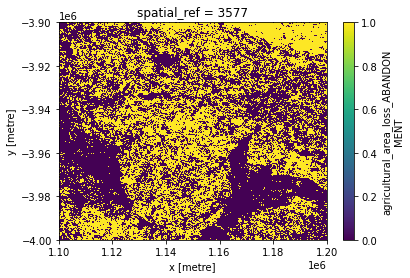

In [241]:
agricultural_area_loss_ABANDONMENT_xarray["agricultural_area_loss_ABANDONMENT"].plot()

In [242]:
export_to_geotiff(agricultural_area_loss_ABANDONMENT_xarray, "outputs/{}_{}-agricultural_area_loss_ABANDONMENT.tif".format(site_name.replace(" ","_"), year))

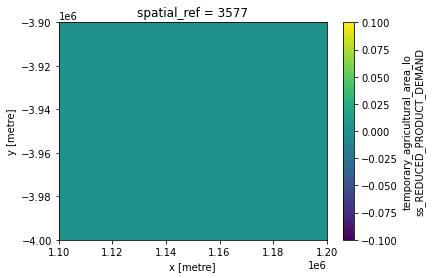

In [243]:
temporary_agricultural_area_loss_REDUCED_PRODUCT_DEMAND_xarray["temporary_agricultural_area_loss_REDUCED_PRODUCT_DEMAND"].plot()

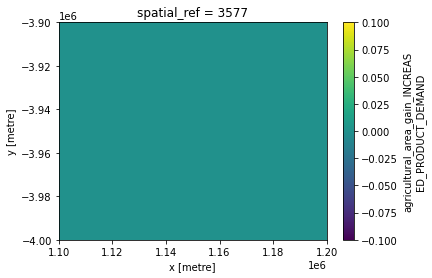

In [244]:
agricultural_area_gain_INCREASED_PRODUCT_DEMAND_xarray["agricultural_area_gain_INCREASED_PRODUCT_DEMAND"].plot()

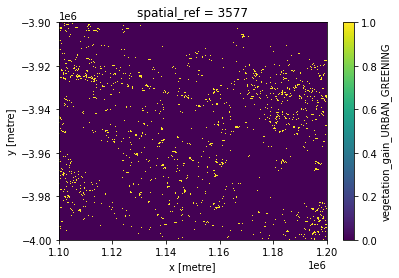

In [245]:
vegetation_gain_URBAN_GREENING_xarray["vegetation_gain_URBAN_GREENING"].plot()

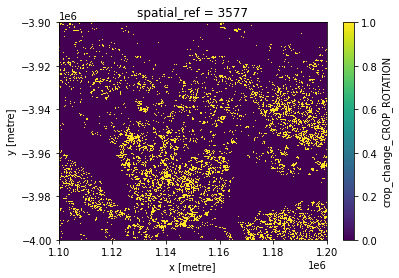

In [246]:
crop_change_CROP_ROTATION_xarray["crop_change_CROP_ROTATION"].plot()

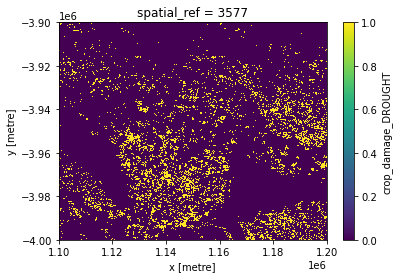

In [247]:
crop_damage_DROUGHT_xarray["crop_damage_DROUGHT"].plot()

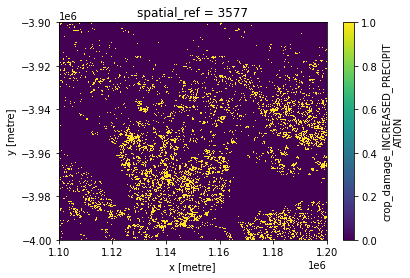

In [248]:
crop_damage_INCREASED_PRECIPITATION_xarray["crop_damage_INCREASED_PRECIPITATION"].plot()

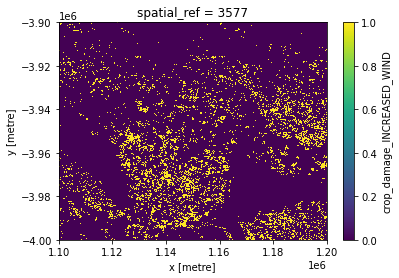

In [249]:
crop_damage_INCREASED_WIND_xarray["crop_damage_INCREASED_WIND"].plot()

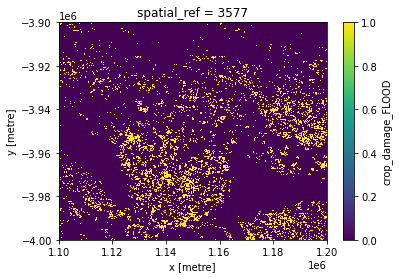

In [250]:
crop_damage_FLOOD_xarray["crop_damage_FLOOD"].plot()

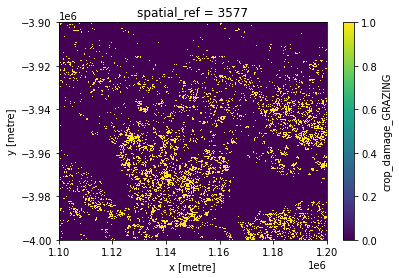

In [251]:
crop_damage_GRAZING_xarray["crop_damage_GRAZING"].plot()

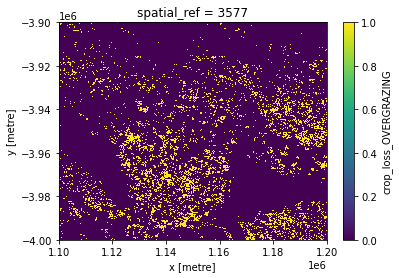

In [252]:
crop_loss_OVERGRAZING_xarray["crop_loss_OVERGRAZING"].plot()

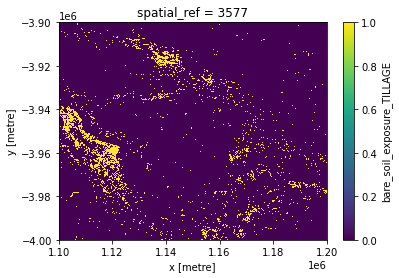

In [253]:
bare_soil_exposure_TILLAGE_xarray["bare_soil_exposure_TILLAGE"].plot()

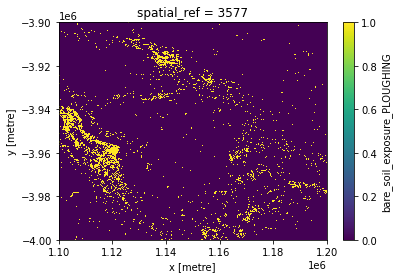

In [254]:
bare_soil_exposure_PLOUGHING_xarray["bare_soil_exposure_PLOUGHING"].plot()

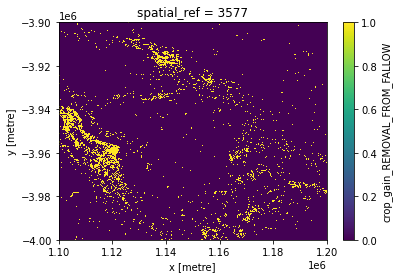

In [255]:
crop_gain_REMOVAL_FROM_FALLOW_xarray["crop_gain_REMOVAL_FROM_FALLOW"].plot()

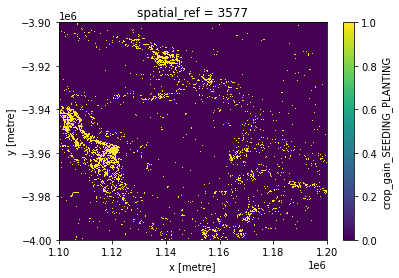

In [256]:
crop_gain_SEEDING_PLANTING_xarray["crop_gain_SEEDING_PLANTING"].plot()

In [ ]:
vegetation_health_improvement_IRRIGATION_xarray["vegetation_health_improvement_IRRIGATION"].plot()

In [ ]:
vegetation_health_improvement_FERTILISER_APPLICATION_xarray["vegetation_health_improvement_FERTILISER_APPLICATION"].plot()

In [ ]:
vegetation_increase_URBAN_GREENING_xarray["vegetation_increase_URBAN_GREENING"].plot()

In [ ]:
vegetation_gain_LAND_ABANDONMENT_xarray["vegetation_gain_LAND_ABANDONMENT"].plot()

In [ ]:
vegetation_gain_AFFORESTATION_xarray["vegetation_gain_AFFORESTATION"].plot()

In [ ]:
vegetation_gain_REVEGETATION_xarray["vegetation_gain_REVEGETATION"].plot()

In [ ]:
vegetation_gain_ENCHROACHMENT_xarray["vegetation_gain_ENCHROACHMENT"].plot()

In [ ]:
vegetation_change_INVASIVE_SPECIES_TERRESTRIAL_xarray["vegetation_change_INVASIVE_SPECIES_TERRESTRIAL"].plot()

In [ ]:
vegetation_change_CONTROL_TERRESTRIAL_INVASIVES_xarray["vegetation_change_CONTROL_TERRESTRIAL_INVASIVES"].plot()

In [ ]:
vegetation_gain_FERTILIZER_APPLICATION_xarray["vegetation_gain_FERTILIZER_APPLICATION"].plot()

In [ ]:
vegetation_gain_SUCCESSION_xarray["vegetation_gain_SUCCESSION"].plot()

In [ ]:
vegetation_gain_REGROWTH_xarray["vegetation_gain_REGROWTH"].plot()

In [ ]:
vegetation_gain_RESTORATION_xarray["vegetation_gain_RESTORATION"].plot()

In [ ]:
vegetation_reduction_PRESCRIBED_BURN_xarray["vegetation_reduction_PRESCRIBED_BURN"].plot()

In [ ]:
dieback_DROUGHT_xarray["dieback_DROUGHT"].plot()

In [ ]:
dieback_HERBIVORY_xarray["dieback_HERBIVORY"].plot()

In [ ]:
dieback_INSECTS_xarray["dieback_INSECTS"].plot()

In [ ]:
dieback_PATHOGENS_xarray["dieback_PATHOGENS"].plot()

In [ ]:
dieback_PROLONGED_INUNDATION_xarray["dieback_PROLONGED_INUNDATION"].plot()

In [ ]:
vegetation_damage_FROST_xarray["vegetation_damage_FROST"].plot()

In [ ]:
vegetation_damage_PROLONGED_SNOWCOVER_xarray["vegetation_damage_PROLONGED_SNOWCOVER"].plot()

In [ ]:
vegetation_loss_WILDFIRE_xarray["vegetation_loss_WILDFIRE"].plot()

In [ ]:
vegetation_reduction_INCREASED_WIND_xarray["vegetation_reduction_INCREASED_WIND"].plot()

In [ ]:
vegetation_reduction_HERBIVORY_xarray["vegetation_reduction_HERBIVORY"].plot()

In [ ]:
vegetation_reduction_DESERTIFICATION_xarray["vegetation_reduction_DESERTIFICATION"].plot()

In [ ]:
vegetation_change_DAY_LENGTH_TEMPERATURE_xarray["vegetation_change_DAY_LENGTH_TEMPERATURE"].plot()

In [ ]:
vegetation_increase_REFORESTATION_NATURAL_xarray["vegetation_increase_REFORESTATION_NATURAL"].plot()

In [ ]:
vegetation_increase_REFORESTATION_PLANTATION_xarray["vegetation_increase_REFORESTATION_PLANTATION"].plot()

In [ ]:
vegetation_loss_DEFORESTATION_xarray["vegetation_loss_DEFORESTATION"].plot()

In [ ]:
vegetation_increase_WOODY_THICKENING_xarray["vegetation_increase_WOODY_THICKENING"].plot()

In [ ]:
vegetation_reduction_SELECTIVE_LOGGING_xarray["vegetation_reduction_SELECTIVE_LOGGING"].plot()

In [ ]:
vegetation_loss_THINNING_xarray["vegetation_loss_THINNING"].plot()

In [ ]:
gain_in_aquaculture_EXPANSION_xarray["gain_in_aquaculture_EXPANSION"].plot()

In [ ]:
loss of aquaculture_ABANDONMENT_xarray["loss of aquaculture_ABANDONMENT"].plot()

In [ ]:
algal_bloom_INCREASED TEMPERATURES_xarray["algal_bloom_INCREASED TEMPERATURES"].plot()

In [ ]:
dieback_SEA_LEVEL_FLUCTUATION_xarray["dieback_SEA_LEVEL_FLUCTUATION"].plot()

In [ ]:
dieback_MOORING_ANCHORING_xarray["dieback_MOORING_ANCHORING"].plot()

In [ ]:
coral_bleaching_INCREASED SEA TEMPERATURES_xarray["coral_bleaching_INCREASED SEA TEMPERATURES"].plot()

In [ ]:
coral_recovery_VEGETATION_HEALTH_IMPROVEMENT_xarray["coral_recovery_VEGETATION_HEALTH_IMPROVEMENT"].plot()

In [ ]:
vegetation_change_AQUATIC_INVASIVES_xarray["vegetation_change_AQUATIC_INVASIVES"].plot()

In [ ]:
vegetation_change_CONTROL_OF_AQUATIC_INVASIVES_xarray["vegetation_change_CONTROL_OF_AQUATIC_INVASIVES"].plot()

In [ ]:
urban_development_CONSTRUCTION_AQUACULTURE_xarray["urban_development_CONSTRUCTION_AQUACULTURE"].plot()

In [ ]:
urban_development_CONSTRUCTION_DAMS_xarray["urban_development_CONSTRUCTION_DAMS"].plot()

In [ ]:
urban_development_CONSTRUCTION_LEVELLING_xarray["urban_development_CONSTRUCTION_LEVELLING"].plot()

In [ ]:
urban_development_CONSTRUCTION_RAILWAYS_xarray["urban_development_CONSTRUCTION_RAILWAYS"].plot()

In [ ]:
urban_development_CONSTRUCTION_ROADS_xarray["urban_development_CONSTRUCTION_ROADS"].plot()

In [ ]:
urban_development_CONSTRUCTION_MINES_xarray["urban_development_CONSTRUCTION_MINES"].plot()

In [ ]:
urban_development_CONSTRUCTION_BUILDINGS_xarray["urban_development_CONSTRUCTION_BUILDINGS"].plot()

In [ ]:
artificial_surface_loss_SUBSIDENCE_xarray["artificial_surface_loss_SUBSIDENCE"].plot()

In [ ]:
mine_abandonment_REDUCED_RESOURCES_DEMAND_xarray["mine_abandonment_REDUCED_RESOURCES_DEMAND"].plot()

In [ ]:
urban_damage_FIRE_xarray["urban_damage_FIRE"].plot()

In [ ]:
urban_damage_URBAN_FIRE_xarray["urban_damage_URBAN_FIRE"].plot()

In [ ]:
urban_damage_INCREASED_WINDS_xarray["urban_damage_INCREASED_WINDS"].plot()

In [ ]:
urban_damage_FLOODING_xarray["urban_damage_FLOODING"].plot()

In [ ]:
urban_decay_BUILDING_ABANDONMENT_xarray["urban_decay_BUILDING_ABANDONMENT"].plot()

In [ ]:
urban_decay_RAILWAY_ABANDONMENT_xarray["urban_decay_RAILWAY_ABANDONMENT"].plot()

In [ ]:
urban_decay_ROAD_ABANDONMENT_xarray["urban_decay_ROAD_ABANDONMENT"].plot()

In [ ]:
urban_development_DENSIFICATION_xarray["urban_development_DENSIFICATION"].plot()

In [ ]:
urban_renewal_STORM_DAMAGE_REPAIR_xarray["urban_renewal_STORM_DAMAGE_REPAIR"].plot()

In [ ]:
landslide_ELEVATION_CHANGE_xarray["landslide_ELEVATION_CHANGE"].plot()

In [ ]:
erosion_FLOODING_xarray["erosion_FLOODING"].plot()

In [ ]:
erosion_INCREASED_WIND_xarray["erosion_INCREASED_WIND"].plot()

In [ ]:
natural_surface_loss_SUBSIDENCE_xarray["natural_surface_loss_SUBSIDENCE"].plot()

In [ ]:
natural_surface_loss_MINING_xarray["natural_surface_loss_MINING"].plot()

In [ ]:
sink_hole_LAND_SURFACE_COLLAPSE_xarray["sink_hole_LAND_SURFACE_COLLAPSE"].plot()

In [ ]:
accretion_SEDIMENT_TRANSPORT_xarray["accretion_SEDIMENT_TRANSPORT"].plot()

In [ ]:
lava_flow_VOLCANIC_ERUPTION_xarray["lava_flow_VOLCANIC_ERUPTION"].plot()

In [ ]:
deposition_NATURAL_SURFACE_GAIN_xarray["deposition_NATURAL_SURFACE_GAIN"].plot()

In [ ]:
deglaciation_INCREASED_TEMPERATURE_xarray["deglaciation_INCREASED_TEMPERATURE"].plot()

In [ ]:
sea_level_fall_OSCILLATION_OCEAN_ATMOSPHERE_SYSTEM_xarray["sea_level_fall_OSCILLATION_OCEAN_ATMOSPHERE_SYSTEM"].plot()

In [ ]:
water_loss_DRYING_xarray["water_loss_DRYING"].plot()

In [ ]:
water_loss_LAND_RECLAMATION_xarray["water_loss_LAND_RECLAMATION"].plot()

In [ ]:
water_loss_WETLAND_WATERBODY_DRAINING_xarray["water_loss_WETLAND_WATERBODY_DRAINING"].plot()

In [ ]:
inundation_INCREASED_PRECIPITATION_xarray["inundation_INCREASED_PRECIPITATION"].plot()

In [ ]:
sea_level_rise_MELTING_ICE_THERMAL_EXPANSION_xarray["sea_level_rise_MELTING_ICE_THERMAL_EXPANSION"].plot()

In [ ]:
blackwater_event_INUNDATION_POST_EXTENDED_DROUGHT_xarray["blackwater_event_INUNDATION_POST_EXTENDED_DROUGHT"].plot()

In [ ]:
increased_sediment_loads_SEDIMENTATION_xarray["increased_sediment_loads_SEDIMENTATION"].plot()

In [ ]:
net_snow_hydroperiod_loss_INCREASED_TEMPERATURE_xarray["net_snow_hydroperiod_loss_INCREASED_TEMPERATURE"].plot()

In [ ]:
salinisation_HIGH_SOIL_SALT_CONCENTRATION_xarray["salinisation_HIGH_SOIL_SALT_CONCENTRATION"].plot()

In [ ]:
water_level_decrease_EVAPOTRANSPIRATION_xarray["water_level_decrease_EVAPOTRANSPIRATION"].plot()

In [ ]:
water_level_decrease_ABSTRACTION_xarray["water_level_decrease_ABSTRACTION"].plot()

In [ ]:
water_level_decrease_DAM_REMOVAL_xarray["water_level_decrease_DAM_REMOVAL"].plot()

In [ ]:
water_level_decrease_DAM_FAILURE_xarray["water_level_decrease_DAM_FAILURE"].plot()

In [ ]:
sea_ice_decrease_INCREASED_TEMPERATURE_xarray["sea_ice_decrease_INCREASED_TEMPERATURE"].plot()

In [ ]:
snowmelt_INCREASED_TEMPERATURE_xarray["snowmelt_INCREASED_TEMPERATURE"].plot()

In [ ]:
desaliniation_IRRIGATION_GYPSUM_APPLICATION_xarray["desaliniation_IRRIGATION_GYPSUM_APPLICATION"].plot()

In [ ]:
net_snow_gain_DECREASED_TEMPERATURE_xarray["net_snow_gain_DECREASED_TEMPERATURE"].plot()

In [ ]:
water_level_increase_FLOODING_xarray["water_level_increase_FLOODING"].plot()

In [ ]:
glaciation_DECREASED_TEMPERATURE_xarray["glaciation_DECREASED_TEMPERATURE"].plot()

In [ ]:
sea_ice_increase_DECREASED_TEMPERATURE_xarray["sea_ice_increase_DECREASED_TEMPERATURE"].plot()

In [ ]:
snow_accumulation_CONSECUTIVE_SNOWFALL_xarray["snow_accumulation_CONSECUTIVE_SNOWFALL"].plot()

In [ ]:
dieback_reduced_inundation = numpy.where((out_evidence_based_change["ntv_woody_extent"]== 2), 1, 0)

In [ ]:
#out_evidence_based_change["ntv_woody_extent"]== 2) & (woody_cover_diff < 0.1) & (woody_cover_time_diff > numpy.timedelta64(6*365, "D")), 1, 0)

In [ ]:
# Copy to xarray. Need to take only spatial dimensions not time from classification_all
dieback_reduced_inundation_xarray = xarray.Dataset(
    {"dieback_reduced_inundation" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_reduced_inundation)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [ ]:
# Plot
dieback_reduced_inundation_xarray["dieback_reduced_inundation"].plot()

In [ ]:
# Export data as a GeoTiff
export_to_geotiff(dieback_reduced_inundation_xarray, "outputs/{}_{}-Dieback_reduced_inundation_2010_2015.tif".format(site_name.replace(" ","_"), year))

#### Dieback (storms)

In [ ]:
dieback_storms = numpy.where((out_evidence_based_change["ntv_woody_ps"
]==2), 1, 0)

In [ ]:
#dieback_storms = numpy.where((out_evidence_based_change["ntv_woody_ps"]==2) & (canopy_cov_diff > 0.1) & (canopy_cov_time_diff > numpy.timedelta64(5*365, "D")), 1, 0)

In [ ]:
# Copy to xarray. Need to take only spatial dimensions not time from classification_all
dieback_storms_xarray = xarray.Dataset(
    {"dieback_storms" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_storms)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [ ]:
# Plot
dieback_storms_xarray["dieback_storms"].plot()

In [ ]:
# Export data as a GeoTiff
export_to_geotiff(dieback_storms_xarray, "outputs/{}_{}-Dieback_storm_2010_2015.tif".format(site_name.replace(" ","_"), year))

#### Water loss (reduced precipitation)

In [ ]:
waterloss_reducedprecip = numpy.where((out_evidence_based_change["water_persistence"]==2), 1, 0)

In [ ]:
#waterloss_reducedprecip = numpy.where((out_evidence_based_change["water_persistence"]==2) & (waterper_wat_diff > 10) & (waterper_wat_time_diff > numpy.timedelta64(5*365, "D")), 1, 0)

In [ ]:
# Copy to xarray. Need to take only spatial dimensions not time from classification_all
waterloss_reducedprecip_xarray = xarray.Dataset(
    {"waterloss_reducedprecip" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, waterloss_reducedprecip)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [ ]:
# Plot
waterloss_reducedprecip_xarray["waterloss_reducedprecip"].plot()

In [ ]:
# Export data as a GeoTiff
export_to_geotiff(waterloss_reducedprecip_xarray, "outputs/{}_{}-Waterloss_reducedprecip_2010_2015.tif".format(site_name.replace(" ","_"), year))

#### Dieback (drought) 

In [ ]:
dieback_drought = numpy.where((out_evidence_based_change["ntv_woody_ps"]==2), 1, 0)

In [ ]:
#dieback_drought = numpy.where((out_evidence_based_change["ntv_woody_ps"]==2) & (canopy_cov_diff < 60) & (canopy_cov_time_diff > numpy.timedelta64(5*365, "D")), 1, 0)

In [ ]:
# Copy to xarray. Need to take only spatial dimensions not time from classification_all
dieback_drought_xarray = xarray.Dataset(
    {"dieback_drought" : ({"y" : classification_all.dims["y"], "x" : classification_all.dims["x"]}, dieback_drought)},
    coords={"y" : classification_all.coords["y"], "x" : classification_all.coords["x"]})

In [ ]:
# Plot
dieback_drought_xarray["dieback_drought"].plot()

In [ ]:
# Export data as a GeoTiff
export_to_geotiff(dieback_drought_xarray, "outputs/{}_{}-Dieback_drought_2010-2015.tif".format(site_name.replace(" ","_"), year))

### END

In [ ]:
# Export data as a GeoTiff
export_parameters = {}
export_parameters["output_file"] = "outputs/{}_2010-2015_evidence_based_change.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.uint16
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL
# Write out xarray
export_obj.write_xarray(dieback_storms_xarray, **export_parameters)